# DeepAR on simulation indy500 laptime dataset

laptime dataset
<eventid, carids, laptime (totalcars x totallaps)>

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets


In [2]:
import pickle
with open('sim-indy500-laptime-2018.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    laptime_data = pickle.load(f, encoding='latin1')

In [3]:
print(f"number of runs: {len(laptime_data)}")

number of runs: 120


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [4]:
laptime_data[2][2].astype(np.float32)

array([[40.352245, 43.218563, 41.9024  , ..., 42.820602, 41.368828,
        42.138153],
       [41.667377, 41.910473, 42.317444, ..., 41.966064, 41.074497,
        41.592945],
       [41.92382 , 41.59292 , 41.28393 , ..., 54.398525, 66.5002  ,
        42.472385],
       ...,
       [43.10438 , 40.880608, 41.726143, ..., 42.130272, 41.089073,
        43.263035],
       [41.25949 , 42.590233, 43.083977, ..., 42.671246, 43.1373  ,
        41.445827],
       [41.704525, 42.149868, 42.95242 , ..., 42.41794 , 42.94077 ,
        41.149597]], dtype=float32)

In [6]:
from gluonts.dataset.common import ListDataset
prediction_length = 50
freq = "1H"
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

train_set = []
test_set = []
cardinality = []
#_data: eventid, carids, laptime array
for _data in laptime_data:
    #_train = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2][:, :-prediction_length]]
    #_test = [{'target': x.astype(np.float32), 'start': start} 
    #        for x in _data[2]]
    carids = list(_data[1].values())
    _train = [{'target': _data[2][rowid, :-prediction_length].astype(np.float32), 'start': start, 
               'feat_static_cat': rowid}             
            for rowid in range(_data[2].shape[0]) ]
    _test = [{'target': _data[2][rowid, :].astype(np.float32), 'start': start, 'feat_static_cat': rowid} 
            for rowid in range(_data[2].shape[0]) ]
    
    train_set.extend(_train)
    test_set.extend(_test)
    cardinality.append(len(carids))




In [19]:
train_set[32]['feat_static_cat']

array([32], dtype=int32)

In [7]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(train_set, freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(test_set, freq=freq)

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

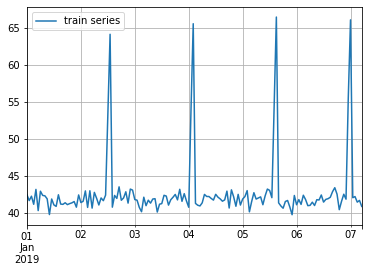

In [8]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

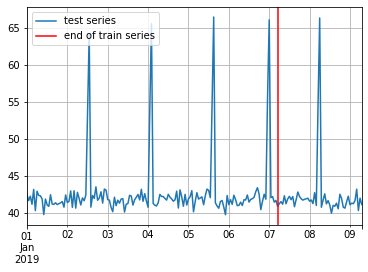

In [9]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [10]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 50
Recommended prediction horizon: 50
Frequency of the time series: 1H


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

INFO:root:Using GPU


In [41]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=2*prediction_length,
    use_feat_static_cat=True,
    cardinality=[33],
    freq=freq,
    trainer=Trainer(ctx="cpu", 
                    epochs=100, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=64
                   )
)

In [28]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=2*prediction_length,
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

INFO:root:Using GPU


After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [42]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.10it/s, avg_epoch_loss=3.24]
INFO:root:Epoch[0] Elapsed time 12.559 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.235555
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.42it/s, avg_epoch_loss=2.04]
INFO:root:Epoch[1] Elapsed time 11.813 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=2.040258
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.46it/s, avg_epoch_loss=1.94]
INFO:root:Epoch[2] Elapsed time 11.727 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.941721
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.45it/s, avg_epoch_loss=1.93]
INFO:root:Epoch[3] Elapsed time 11.751 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.925145
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.52it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.47it/s, avg_epoch_loss=1.8] 
INFO:root:Epoch[37] Elapsed time 11.705 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1.795867
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.24it/s, avg_epoch_loss=1.81]
INFO:root:Epoch[38] Elapsed time 12.222 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1.810246
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.28it/s, avg_epoch_loss=1.78]
INFO:root:Epoch[39] Elapsed time 12.115 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1.782837
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.52it/s, avg_epoch_loss=1.8]
INFO:root:Epoch[40] Elapsed time 11.606 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=1.798631
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.49it/s, avg_epoch_loss=1.78]
INFO:root

100%|██████████| 64/64 [00:11<00:00,  5.42it/s, avg_epoch_loss=1.61]
INFO:root:Epoch[74] Elapsed time 11.802 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=1.613442
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.45it/s, avg_epoch_loss=1.63]
INFO:root:Epoch[75] Elapsed time 11.738 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.630203
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.51it/s, avg_epoch_loss=1.62]
INFO:root:Epoch[76] Elapsed time 11.623 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.621834
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.50it/s, avg_epoch_loss=1.62]
INFO:root:Epoch[77] Elapsed time 11.637 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.617092
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 64/64 [00:11<00:00,  5.49it/s, avg_epoch_loss=1.62]
INFO:root:Epoch[78] Elapsed time 11.666 seconds
INF

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [43]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [44]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [45]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [ ]:
# first entry of the time series list
ts_entry = tss[0]

In [ ]:
len(ts_entry)

In [ ]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[-10:]).reshape(-1,)

In [ ]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [ ]:
# first 5 values
dataset_test_entry['target'][-10:]

In [ ]:
len(tss[0])

In [ ]:
forecasts[0].samples.shape

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [58]:
# first entry of the forecast list
# Indy500 Car 12 WillPower
ts_entry = tss[7]
forecast_entry = forecasts[7]

In [48]:
forecast_entry.samples[0,:]

array([42.39224 , 42.71629 , 42.344505, 42.46224 , 44.38521 , 43.30208 ,
       42.017925, 41.255768, 42.52207 , 43.82131 , 42.804413, 42.38063 ,
       44.07478 , 42.561092, 41.068913, 40.8167  , 42.098568, 42.139366,
       41.048523, 43.456436, 42.817253, 42.469288, 44.631557, 43.256348,
       42.547028, 40.95539 , 41.740623, 41.293736, 41.51575 , 43.14943 ,
       40.371307, 41.200756, 42.70724 , 41.512028, 40.814194, 41.590687,
       41.625168, 41.748394, 38.425323, 40.18762 , 44.14611 , 39.490532,
       42.82657 , 43.524334, 42.064606, 44.590836, 39.073338, 43.036736,
       40.89927 , 42.304024], dtype=float32)

In [49]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 50)
Start date of the forecast window: 2019-01-07 06:00:00
Frequency of the time series: 1H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [50]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [42.385937 42.624058 42.255836 42.658337 42.599087 42.611748 42.53383
 42.46092  42.351383 42.119896 42.68523  42.749966 42.229115 42.043438
 42.083824 42.5626   42.5718   42.22913  42.53733  42.417202 42.300846
 41.94221  42.102814 41.85521  41.955456 42.062916 42.030006 41.019684
 41.197792 42.147324 42.170708 41.87097  42.059273 41.862858 42.118008
 41.854053 41.902607 41.749012 41.634907 41.770576 42.137943 42.335293
 42.00937  41.891884 41.823963 41.435844 41.351128 41.419483 41.27005
 41.383877]
0.5-quantile (median) of the future window:
 [42.35027  42.698727 42.30153  42.663868 42.4594   42.634594 42.45551
 42.488205 42.441948 42.234024 42.534863 42.59742  42.107037 42.355568
 42.066563 42.41307  42.268005 42.29679  42.253487 42.325474 42.266037
 41.790234 42.019432 41.83005  42.009064 42.027237 41.922073 41.009525
 41.254303 41.965588 42.17046  41.920006 42.193897 41.92161  42.04187
 41.689114 41.823616 41.748394 41.79965  41.89846  42.249043 41.971

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [51]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

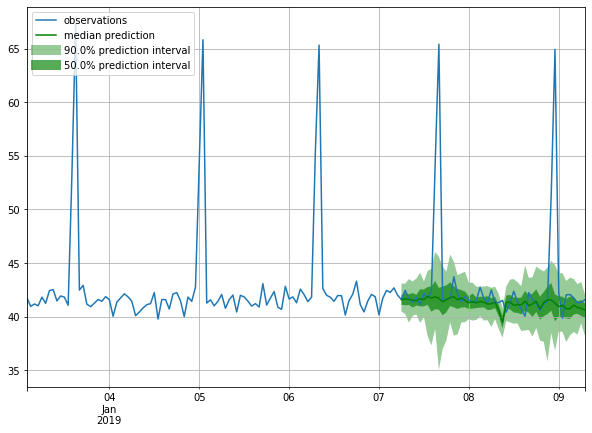

In [59]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [53]:
from gluonts.evaluation import Evaluator

In [54]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 3960/3960 [00:29<00:00, 132.44it/s]


Aggregate metrics aggregate both across time-steps and across time series.

In [55]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 21.89500751194809,
    "abs_error": 332201.3260688782,
    "abs_target_sum": 8510522.005615234,
    "abs_target_mean": 42.98243437179411,
    "seasonal_error": 3.031913744602445,
    "MASE": 0.5538275090968439,
    "sMAPE": 0.0354323911343418,
    "MSIS": 12.621910914041486,
    "QuantileLoss[0.1]": 121915.51224899292,
    "Coverage[0.1]": 0.034656565656565656,
    "QuantileLoss[0.5]": 332201.3261833191,
    "Coverage[0.5]": 0.3784141414141414,
    "QuantileLoss[0.9]": 360779.74413375853,
    "Coverage[0.9]": 0.8627575757575758,
    "RMSE": 4.679210137613835,
    "NRMSE": 0.10886331139690919,
    "ND": 0.039034189189534094,
    "wQuantileLoss[0.1]": 0.014325268434598158,
    "wQuantileLoss[0.5]": 0.03903418920298108,
    "wQuantileLoss[0.9]": 0.042392199197148706,
    "mean_wQuantileLoss": 0.031917218944909315,
    "MAE_Coverage": 0.0747239057239057
}


Individual metrics are aggregated only across time-steps.

In [56]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,15.919058,62.044842,2118.346680,42.366934,2.790739,0.444648,0.026251,11.115599,23.448229,0.06,62.044842,0.50,75.895338,0.94
1,NaN,16.041115,63.462650,2110.306641,42.206133,2.798099,0.453613,0.026892,10.449544,23.216056,0.02,63.462650,0.54,71.187105,0.94
2,NaN,16.566250,67.948715,2136.522705,42.730454,2.955661,0.459787,0.028647,10.421807,28.778062,0.02,67.948711,0.38,74.353561,0.94
3,NaN,25.300801,96.008949,2160.721680,43.214434,2.666542,0.720101,0.040316,17.907152,30.928972,0.02,96.008953,0.34,112.537551,0.84
4,NaN,25.463774,93.479233,2213.656738,44.273135,3.864950,0.483728,0.038105,10.041734,35.248159,0.04,93.479229,0.40,96.990172,0.90


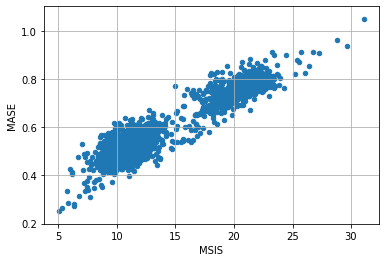

In [57]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()